# Week 6 - Prediction & Causal Inference

Last week, we explored (supervised) text classification, where we train a model to learn associations between text and some classification or value connected with it (e.g., what distinguishes a winning argument before the Supreme Court; can we extend our judgment regarding what documents are relevant to my thesis project to all of Google News; etc.) Classification often uses a representative sample of text about which we want to make inferences and then we use machine learning to learn "true" assignments and classify the rest.

This week, we explore two different types of inferences to out-of-sample populations. _Prediction_ involves our reasoned expectation regarding an unobserved state of the world, given the world in which we live and on which we have trained our prediction algorithm. Often this prediction is about the future world. We don't expect the U.S. Congress to talk about the identical things today and tomorrow, but today should contain some useful information. by contrast _causal inference_ poses the related by distinct challenge of our reasoned expectations regarding an unobserved state of the world IF we intervene in some way. In other words, what does the intervention cause, and how can we predict it to change the world. Causality has a deeply contested history in social science and philosophy, but it usually involves an "if," a difference between two counterfactual worlds, one where an event occurs and one where it doesn't.

Causal questions in text analysis may place the text in one or more of many positions we explore below: as cause, effect, confounder, mediator (or moderator), or collider. For example, assuming that everything spoken can be transcribed into text, saying something mean might hurt someone's feelings (text as cause). Doing something mean might cause someone to say something angry (text as effect). Apologizing might change the influence of doing something mean (text as mediator/moderator). A compliment might obscure the effect of doing something mean (text as confounder). And yelling something audaciously mean might yield a loud, emotional response, which both influence the likelihood that the interaction was recorded and subjected to analysis (text as collider). As you can see, in a single conversation, text can play all of these roles. Why do we care about cause and effect with text? Because while words appear to exert power in the world, which words spoken under what circumstances by whom? Causal analysis attempts to get at the question, if _X_ was written or spoken, _Y_ would happen.

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import os #For managing the operating system
import requests #For getting files
import zipfile #For managing zips
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas as pd #Gives us DataFrames
import numpy as np #Math and matrices
import matplotlib.pyplot as plt #For graphics

# statsmodels is a popular Python statistics package
import statsmodels.api as sm
# Let's also import its graphics module
import statsmodels.graphics.api as smg
# And the mediation module
from statsmodels.stats.mediation import Mediation

# Pipelines to add text-based quantiative variables for regressions
from transformers import pipeline

# We have a lot of features, so let's set Pandas to show all of them.
pd.set_option('display.max_columns', None)

# Prediction
We can make predictions about a range of different text 'populations'. We can use texts in English to predict their translations in French. We can use newspaper articles from 2012 to 2022 to forecast the contents of 2023 newspaper articles (e.g., a [time series](https://en.wikipedia.org/wiki/Time_series)). Or we can "nowcast" by using real-time social information such as Tweets to predict when an important event is happening, such as a riot.

If we don't have any information about how the new population will vary from the population we modeled, then prediction is implemented in the same way as in-sample inference. E.g., if you have a categorization of 2022 emails as spam or ham, you could predict whether 2023 emails are spam the same way you predicted 2022 emails. On the other hand, if you have new information, such as a trend beginning in December 2022 for spam emails to have "Urgent:" in the subject line, your 2023 prediction may differ by putting more weight on that indicator relative to others.

In this way, prediction is similar to the classifications we performed last last week, incorporating multidimensional trends (e.g., time, place, source) learnable from your current corpus. We encourage you to think more about this if you are interested in predicting the future of your corpus!

## <font color="red">*Exercise 1*</font>

<font color="red">Describe 2 separate predictions relevant to your project and associated texts, which involve predicting text that has not been observed based on patterns that have. Then, in a single, short paragraph, describe a research design through which you could use textual features and the tools of classification and regression to evaluate these predictions.

In my project, I'll be using text as a source, and as a predictor of social event. I am trying to study
how echo chambers arise as a result of conflicts and content moderation on social media platforms leading them
to shift base to other platforms that are less restrictive.
Prediction 1 - Assuming 2 groups are at loggerheads in a debate, although the username does not reveal much
information about the person, the activity (like, share) and the text in comment can provide us insights about
who belongs to which group, who has whose back and who attacks whom based on these activities. And when a new
activity is recorded, the group the user is closely affiliated/ inclined towards can be predicted based
on similar previous activities recorded.
Prediction 2 - Based on the content of the comments made, and the previous knowledge of the effects of such activities,
one could predict social events like the start of a debate, volunteer moderation stepping in, users leaving the
community. It is important to learn the composition and diversity of the community to be able to predict such events
effectively.

I plan to use topic modelling to identify relevant topics to characterise what usually causes conflicts
given a particular population. Distinguishing or fighting words could also be used to identify animosity
and based on a user's new activity, the user can be classified using K- nearest neighbours to fit to a community
they are inclined to support.
I also plan to build a logistic regressor with sentiment analysis and other recorded activities for a given community
to model if a particular comment can cause the user to be banned, or if it can start a debate or make another user
quit the community if targeted.

# Text in causal inference

In causal inference, we are interested in the effect of a _treatment_ on an _outcome_. There are five types of variables that could be directly involved in our causal model, and any could be a text variable. This figure from [Keith et al. 2020](https://aclanthology.org/2020.acl-main.474.pdf) concisely shows the five positions for variables in acyclic (i.e., no arrows flow back into themselves) causal inference: treatment, mediator, outcome, confounder, and collider.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" style="width:500px">

"Text as treatment" means the effect of text on other variables. For example, how does the news coverage of a politician affect their election chance? How does the sentiment of a Reddit post affect its upvotes?

Whether we're interested in text as treatment, mediator, outcome, or confounder, we have at our disposal the same causal inference strategies used with other forms of data, such as matching, difference in difference, regression discontinuity, and instrumental variables. Each of these methods usually gives you a more precise conditional identification of the causal influence than regressing an effect on a singular (purported) cause. For example, one of the readings for this week, [Saha 2019](https://doi.org/10.1145/3292522.3326032), uses propensity score matching, which is a straightforward method that works on most datasets (see Professor Gary King on [coarsened exact matching](https://www.youtube.com/watch?v=tvMyjDi4dyg)). For this assignment, we do not detail each of these causal strategies, but note several courses at UChicago that introduce these methods, as well as online textbooks (e.g., Scott Cunningham's [Causal Inference: The Mixtape](https://mixtape.scunning.com/)).

You can do causal inference on any sort of text data as long as you have a plausible _identification_ strategy, meaning an argument that you can correctly identify a causal effect if one exists using your data and analysis. For example, if you have a data from a randomized controlled trial (RCT) where you intervene randomly with some treatment, you can identify a causal effect with relative ease. Text exhibits a wide array of dependencies making unconditional randomization impossible, but we will attempt strategies that approach it. 

# Text as treatment and outcome

To illustrate text as treatment and outcome, we will analyze a dataset of internet arguments. We have 8,895 pairs of comments, where one person makes a statement and the other responds. Our research question is thus: _How does the text of the first commenter affect the text of the respondent?_

The data comes from the [Internet Argument Corpus](https://nlds.soe.ucsc.edu/iac). Let's load the data and take a look.

In [3]:
url = 'http://nldslab.soe.ucsc.edu/iac/iac_v1.1.zip'

req = requests.get(url)

filename = url.split('/')[-1]
with open(filename,'wb') as output_file:
    output_file.write(req.content)
print('Downloaded file: ' + url)

Downloaded file: http://nldslab.soe.ucsc.edu/iac/iac_v1.1.zip


In [5]:
with zipfile.ZipFile('iac_v1.1.zip') as z:
   with z.open('iac_v1.1/data/fourforums/annotations/mechanical_turk/qr_averages.csv') as f:
      qr = pd.read_csv(f)

   with z.open('iac_v1.1/data/fourforums/annotations/mechanical_turk/qr_meta.csv') as f:
      md = pd.read_csv(f)

# columns = ['key', 'nicenasty', 'questioning-asserting', 'negotiate-attack', 'fact-feeling']
# qr_sub = qr[columns]
# qr_sub = qr

pairs = qr.merge(md, how='inner', on='key')
pairs = pairs[~pairs.quote_post_id.isnull() & ~pairs.response_post_id.isnull()]
pairs

,key,discussion_id_x,agree-disagree,agreement,agreement_unsure,attack,attack_unsure,defeater-undercutter,defeater-undercutter_unsure,fact-feeling,fact-feeling_unsure,negotiate-attack,negotiate-attack_unsure,nicenasty,nicenasty_unsure,personal-audience,personal-audience_unsure,questioning-asserting,questioning-asserting_unsure,sarcasm,sarcasm_unsure,discussion_id_y,response_post_id,quote_post_id,term,task1 num annot,task2 num annot,task2 num disagree,quote,response
0,"(731, 1)",6032,0.333333,-1.333333,0.333333,0.333333,0.000000,0.500000,0.000000,0.333333,0.333333,3.000000,0.250000,0.666667,0.166667,-2.250000,0.250000,-4.250000,0.000000,0.200000,0.166667,6032,149609,149552.0,None,6,6,4,I remember looking at the classic evolutionary...,Why do you find it necessary to fit observatio...
1,"(660, 3)",10217,0.600000,0.285714,0.000000,0.714286,0.000000,-2.500000,0.000000,1.000000,0.000000,-2.000000,0.000000,1.142857,0.000000,-1.500000,0.000000,0.500000,0.000000,0.142857,0.000000,10217,277697,277459.0,yes,7,5,2,So they (pro-life peeps) say abortion is murde...,"Yes, you are missing something. How come age d..."
2,"(114, 5)",3462,0.600000,-1.500000,0.000000,1.333333,0.000000,1.000000,0.000000,1.500000,0.000000,-1.500000,0.000000,2.166667,0.000000,-4.000000,0.000000,-1.500000,0.000000,0.000000,0.000000,3462,76012,75976.0,No terms in first 10,6,5,2,'If the solar system was brought about by an a...,"C.S.Lewis believes things on faith, yet we are..."
3,"(43, 3)",9930,0.166667,-0.833333,0.333333,1.500000,0.000000,0.400000,0.000000,1.500000,0.166667,-2.000000,0.000000,1.666667,0.000000,-2.800000,0.000000,0.000000,0.000000,0.000000,0.000000,9930,264824,264697.0,well,6,6,5,...to ToE because it means genetic evolution i...,"Well, it might help if you could propose a mec..."
4,"(1314, 0)",5352,0.142857,-1.666667,0.166667,0.000000,0.166667,-1.166667,0.166667,-0.833333,0.333333,0.833333,0.333333,0.166667,0.166667,-3.333333,0.166667,-0.166667,0.166667,0.600000,0.166667,5352,128326,128325.0,you,6,7,6,Sir Issac Newton was an idiot and you are a ge...,"You really think so? Im flattered, but I think..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"(580, 4)",821,0.800000,-2.000000,0.166667,-0.500000,0.166667,1.000000,0.000000,1.333333,0.166667,-1.000000,0.000000,0.500000,0.166667,0.000000,0.000000,0.000000,0.000000,0.200000,0.166667,821,67788,67785.0,oh,6,5,1,Why do some of you guys insist on being rabid ...,oh because for the past decade or so they have...
9997,"(694, 4)",9258,0.000000,-3.200000,0.200000,0.200000,0.200000,-1.800000,0.000000,1.600000,0.400000,-1.200000,0.200000,0.600000,0.200000,-1.600000,0.000000,1.800000,0.000000,0.000000,0.200000,9258,241951,241848.0,but,5,5,5,But I see two people involved here. Whether th...,But the embryo is a mere clump of flesh inside...
9998,"(916, 6)",10301,0.000000,-3.000000,0.000000,-2.400000,0.000000,-2.400000,0.000000,-2.400000,0.000000,2.800000,0.000000,-2.400000,0.000000,-4.200000,0.000000,1.800000,0.000000,0.000000,0.200000,10301,281530,281509.0,None,5,5,5,I disagree with you because the logic you have...,**\n Sez u. Your problem being that when you a...
9999,"(1348, 1)",6032,0.857143,0.800000,0.600000,0.600000,0.200000,3.000000,0.000000,-0.600000,0.400000,-3.000000,0.000000,0.600000,0.200000,3.000000,0.000000,3.000000,0.000000,0.000000,0.200000,6032,149609,149552.0,No terms in first 10,5,7,1,What I don't understand is why YEC's want to L...,That's what faith does. It limits your options.


Note that each comment and response were annotated by workers on Amazon Mechanical Turk, which we piloted last week. Variables like "agree-disagree" are the averages of annotations made by workers on Mechanical Turk on an 11-point Likert scale (-5 to 5) using a slider. Workers were asked questions, and then had the opportunity to note whether or not their were "unsure" about their assessment (Boolean - Y/N):

* __agree/disagree__ (Boolean -- Y/N): Does the respondent agree (0) OR disagree (1) with the prior post?
* __sarcasm__ (Boolean -- Y/N): Is the respondent using sarcasm (1 - Y; 0 - N)?
* __fact/feeling__  (-5 to 5): Is the respondent attempting to make a fact based argument (-5) OR appealing to feelings and emotions (+5)?
* __attack/insult__ (-5 to 5): Is the respondent being supportive/respectful (-5) OR are they attacking/insulting in their writing (+5)?
* __nice/nasty__ (-5 to 5): Is the respondent attempting to be nice (-5) OR is their attitude fairly nasty (+5)?
* __audience__ (-5 to 5): Is the respondent's arguments intended more to be interacting directly with the original poster (-5) OR with a wider audience (+5)?
* __undercutting__ (-5 to 5): Is the argument of the respondent targeted at the entirety of the original poster's argument (-5) OR is the argument of the respondent targed at a more specific idea within the post (+5)?
* __negotiate/attack__ (-5 to 5): Does the respondent seem to have an argument of their own (-5) OR is the respondent simply attacking the original poster's argument (+5)?
* __question/assert__ (-5 to 5): Is the respondent questioning the original poster (-5) OR is the respondent asserting their own ideas (+5)?

Unfortunately the dataset only has the "response" annotated, not the original "quote." However, some "responses" in this dataset are also "quotes," meaning we can form triples of quote-response-response. Let's self-merge this dataframe to get these "r1" and "r2" pairs where both texts have annotations.

In [11]:
# Self-merge where the 'response' matches another 'quote' in the DataFrame
triples = pairs.merge(pairs,left_on='response',right_on='quote',how='inner',suffixes=('_r1','_r2'))

# Rename and reorder columns
triples = triples.rename(columns={'quote_r1':'quote', 'quote_r2':'response1', 'response_r2':'response2'})
triples = triples.drop(columns=['response_r1'])
front_columns = [
                 'quote','response1','response2','attack_r1','fact-feeling_r1','nicenasty_r1','sarcasm_r1',
                 'agreement_r2'
                ]
triples = triples.dropna(subset=front_columns)
triples = triples[front_columns].join(triples.drop(columns=front_columns))

# Display triples
triples

,quote,response1,response2,attack_r1,fact-feeling_r1,nicenasty_r1,sarcasm_r1,agreement_r2,key_r1,discussion_id_x_r1,agree-disagree_r1,agreement_r1,agreement_unsure_r1,attack_unsure_r1,defeater-undercutter_r1,defeater-undercutter_unsure_r1,fact-feeling_unsure_r1,negotiate-attack_r1,negotiate-attack_unsure_r1,nicenasty_unsure_r1,personal-audience_r1,personal-audience_unsure_r1,questioning-asserting_r1,questioning-asserting_unsure_r1,sarcasm_unsure_r1,discussion_id_y_r1,response_post_id_r1,quote_post_id_r1,term_r1,task1 num annot_r1,task2 num annot_r1,task2 num disagree_r1,key_r2,discussion_id_x_r2,agree-disagree_r2,agreement_unsure_r2,attack_r2,attack_unsure_r2,defeater-undercutter_r2,defeater-undercutter_unsure_r2,fact-feeling_r2,fact-feeling_unsure_r2,negotiate-attack_r2,negotiate-attack_unsure_r2,nicenasty_r2,nicenasty_unsure_r2,personal-audience_r2,personal-audience_unsure_r2,questioning-asserting_r2,questioning-asserting_unsure_r2,sarcasm_r2,sarcasm_unsure_r2,discussion_id_y_r2,response_post_id_r2,quote_post_id_r2,term_r2,task1 num annot_r2,task2 num annot_r2,task2 num disagree_r2
0,I remember looking at the classic evolutionary...,Why do you find it necessary to fit observatio...,"Evolution has no goals, it is merely a beautif...",0.333333,0.333333,0.666667,0.200000,-2.833333,"(731, 1)",6032,0.333333,-1.333333,0.333333,0.000000,0.500000,0.0,0.333333,3.000000,0.25,0.166667,-2.250000,0.25,-4.250000,0.0,0.166667,6032,149609,149552.0,None,6,6,4,"(610, 2)",6032,0.600000,0.166667,0.333333,0.166667,-3.50,0.0,1.333333,0.166667,3.500000,0.0,0.500000,0.333333,-4.000000,0.0,1.500000,0.0,0.0,0.166667,6032,149673,149609.0,None,6,5,2
1,What is the fun in that?,"Seriously? Well, I come here hoping for someth...","nah, I was just poking fun because I can! Pers...",-0.600000,-2.200000,0.000000,0.000000,-2.166667,"(697, 2)",5205,0.833333,-2.400000,0.000000,0.000000,-5.000000,0.0,0.000000,2.000000,0.00,0.000000,0.000000,0.00,-2.000000,0.0,0.000000,5205,122800,122780.0,None,5,6,1,"(1267, 0)",5205,0.600000,0.333333,0.833333,0.166667,-1.50,0.0,-1.333333,0.500000,2.000000,0.0,0.500000,0.166667,-3.000000,0.0,-1.500000,0.0,0.2,0.166667,5205,123129,122800.0,None,6,5,2
2,"First off, the scientific method goes:\n \n 1)...",You guys know me. Always happy to correct anyo...,"Ah, thanks for the correction, although there ...",2.400000,2.800000,2.200000,0.000000,-0.400000,"(9, 0)",9449,0.400000,0.600000,0.200000,0.200000,-2.666667,0.0,0.200000,-3.666667,0.00,0.200000,0.333333,0.00,3.666667,0.0,0.200000,9449,247240,247225.0,you,5,5,3,"(1393, 1)",9449,1.000000,0.200000,0.800000,0.200000,NaN,NaN,1.200000,0.200000,NaN,NaN,1.000000,0.400000,NaN,NaN,NaN,NaN,0.0,0.400000,9449,247243,247240.0,No terms in first 10,5,7,0
3,You can ignore the obvious question. This is w...,Actually what they are really doing is ignorin...,"Really, then show me how I'm wrong - without d...",-3.500000,-3.166667,-3.166667,0.166667,-1.833333,"(1077, 1)",3467,0.400000,-4.333333,0.000000,0.000000,-4.666667,0.0,0.000000,-0.666667,0.00,0.000000,-2.000000,0.00,3.000000,0.0,0.000000,3467,73741,73738.0,actually,6,5,3,"(622, 1)",3467,0.600000,0.166667,-1.333333,0.166667,2.50,0.0,0.333333,0.166667,1.500000,0.0,0.000000,0.166667,0.000000,0.0,-1.500000,0.0,0.2,0.166667,3467,73783,73741.0,really,6,5,2
4,Its really sad what these gay predator priests...,Homosexuals are attracted to adults of the sam...,Homosexuals are attracted to people of the sam...,0.166667,2.166667,-0.166667,0.400000,-2.666667,"(611, 0)",4337,0.333333,-2.000000,0.166667,0.166667,-0.750000,0.0,0.166667,-2.000000,0.00,0.166667,0.000000,0.00,3.750000,0.0,0.166667,4337,112008,111931.0,No terms in first 10,6,6,4,"(1350, 0)",4337,0.428571,0.000000,1.166667,0.000000,-2.50,0.0,0.666667,0.000000,-1.750000,0.0,1.166667,0.000000,-1.250000,0.0,3.250000,0.0,0.0,0.000000,4337,112012,112008.0,No terms in first 10,6,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Now we have 1,346 triples of quote-response1-response2, several text variables of response1 (e.g., "Is the respondent using sarcasm?") that may predict the agreement of response2. In other words: _Does a sarcastic comment lead to more agreement?_ Of course, as with almost all observational data, there are a number of confounders that make our identification difficult, but for now, let's explore how to run a simple regression in Python of agreement_r2 (dependent variable, commonly known as Y) on sarcasm_r1. Fortunately, we do have a strong case for identifying the direction of causality: Because response1 comes before response2, we can rule out the possibility that response2 affects response1.

In [7]:
triples.keys()

Index(['quote', 'response1', 'response2', 'attack_r1', 'fact-feeling_r1',
       'nicenasty_r1', 'sarcasm_r1', 'agreement_r2', 'key_r1',
       'discussion_id_x_r1', 'agree-disagree_r1', 'agreement_r1',
       'agreement_unsure_r1', 'attack_unsure_r1', 'defeater-undercutter_r1',
       'defeater-undercutter_unsure_r1', 'fact-feeling_unsure_r1',
       'negotiate-attack_r1', 'negotiate-attack_unsure_r1',
       'nicenasty_unsure_r1', 'personal-audience_r1',
       'personal-audience_unsure_r1', 'questioning-asserting_r1',
       'questioning-asserting_unsure_r1', 'sarcasm_unsure_r1',
       'discussion_id_y_r1', 'response_post_id_r1', 'quote_post_id_r1',
       'term_r1', 'task1 num annot_r1', 'task2 num annot_r1',
       'task2 num disagree_r1', 'key_r2', 'discussion_id_x_r2',
       'agree-disagree_r2', 'agreement_unsure_r2', 'attack_r2',
       'attack_unsure_r2', 'defeater-undercutter_r2',
       'defeater-undercutter_unsure_r2', 'fact-feeling_r2',
       'fact-feeling_unsure_r2', '

In [5]:
# We build an Ordinary Least Squares (OLS) model of agreement_r2 on sarcasm_r1.
# The function sm.add_constant() adds an intercept term to the regression (e.g., b in y = ax + b)
y = triples['agreement_r2']
X_cols = ['sarcasm_r1']
X = sm.add_constant(triples[X_cols])

lm1 = sm.OLS(y,X).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           agreement_r2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03364
Date:                Tue, 22 Feb 2022   Prob (F-statistic):              0.855
Time:                        10:03:20   Log-Likelihood:                -2581.1
No. Observations:                1340   AIC:                             5166.
Df Residuals:                    1338   BIC:                             5177.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2805      0.058    -22.263      0.000      -1.393      -1.168
sarcasm_r1    -0.0383      0.209     -0.183      0.855      -0.448       0.371
==============================================================================
Omnibus:                       86.710   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.903
Skew:                           0.642   Prob(JB):                     4.52e-23
Kurtosis:                       3.443   Cond. No.                         4.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for sarcasm_r1 is 0.855, which means that we fail to reject the null hypothesis that there is no effect of sarcasm on agreement. However, we have other variables that may be confounding the effect of pure "attack" or pure "sarcasm." Let's try adding 3 other annotations to the regression model.

In [6]:
y = triples['agreement_r2']
X_cols = ['attack_r1','fact-feeling_r1','nicenasty_r1','sarcasm_r1']
X = sm.add_constant(triples[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           agreement_r2   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     12.60
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           4.54e-10
Time:                        10:03:20   Log-Likelihood:                -2556.3
No. Observations:                1340   AIC:                             5123.
Df Residuals:                    1335   BIC:                             5149.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5276      0.075    -20.497      0.000      -1.674      -1.381
attack_r1           0.1808      0.073      2.475      0.013       0.038       0.324
fact-feeling_r1    -0.0248      0.033     -0.742      0.458      -0.090       0.041
nicenasty_r1        0.0748      0.079      0.951      0.342      -0.079       0.229
sarcasm_r1          0.6972      0.240      2.905      0.004       0.226       1.168
==============================================================================
Omnibus:                       86.269   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.200
Skew:                           0.629   Prob(JB):                     3.89e-23
Kurtosis:                       3.517   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The condition number (bottom-right of the output above) is 12.8, indicating high correlations between our predictors or collinearity. This is one of many issues to look out for when running regressions. Let's take a look at the correlations:

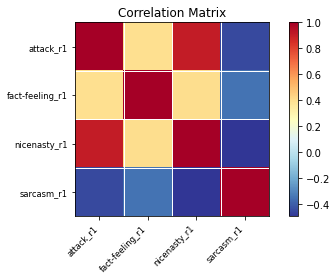

In [7]:
corr_matrix = np.corrcoef(triples[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

That's very high correlation between attack_r1 and nicenasty_r1 (recall that nasty is +5...this should be no surprise)! We found a significant effect of attack_r1, but not of nicenasty_r1. If we remove attack_r1 from the model, do you think nicenasty_r1 will be significant?

In [8]:
y = triples['agreement_r2']
X_cols = ['fact-feeling_r1','nicenasty_r1','sarcasm_r1']
X = sm.add_constant(triples[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           agreement_r2   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     14.71
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           2.00e-09
Time:                        10:03:20   Log-Likelihood:                -2559.3
No. Observations:                1340   AIC:                             5127.
Df Residuals:                    1336   BIC:                             5147.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5744      0.072    -21.798      0.000      -1.716      -1.433
fact-feeling_r1    -0.0183      0.033     -0.548      0.584      -0.084       0.047
nicenasty_r1        0.2454      0.038      6.488      0.000       0.171       0.320
sarcasm_r1          0.7113      0.240      2.959      0.003       0.240       1.183
==============================================================================
Omnibus:                       85.105   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.648
Skew:                           0.623   Prob(JB):                     8.46e-23
Kurtosis:                       3.518   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Yes, it is! And the t-value is even larger (i.e., stronger evidence of an effect). With this new regression model, we see a significant effect from attack_r1/nicenasty_r1 and sarcasm_r1, indicating both of these dimensions affect whether the response2 agrees with response1. Note that the coefficients are both positive: For attack_r1/nicenasty_r1, this means that a more "nasty" comment led to more disagreement, and for sarcasm_r1, this means that a more sarcasistic comment led to more disagreement.

For good measure, we can add other variables ourselves, such as sentiment and the character length of the comment. The length may be particularly important based on how it affects the annotations of Mechanical Turk workers. For example, as we were skimming through the data, it seemed like shorter comments were being rated as more nasty. For sentiment, let's use the convenient BERT pipeline we used last week and which we will detail and theorize in weeks to come.

In [13]:
triples['length_r1'] = triples['response1'].apply(lambda x: len(x))
triples['length_r2'] = triples['response2'].apply(lambda x: len(x))

<ipython-input-13-b888f3d8c138>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triples['length_r1'] = triples['response1'].apply(lambda x: len(x))
<ipython-input-13-b888f3d8c138>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triples['length_r2'] = triples['response2'].apply(lambda x: len(x))


In [14]:
sentiment = pipeline("sentiment-analysis")
result = sentiment("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


label: NEGATIVE, with score: 0.9991


This version of BERT is built only for texts of up to 512 tokens, so for comments longer than that, we truncate.

In [15]:
%%time

triples['sentiment_r1'] = triples['response1'].apply(lambda x: sentiment(x[:512])[0]['score'])
triples['sentiment_r2'] = triples['response2'].apply(lambda x: sentiment(x[:512])[0]['score'])

<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 5min 57s, sys: 2.29 s, total: 5min 59s
Wall time: 5min 51s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
triples = triples.dropna(subset=['personal-audience_r2'])
y = triples['agreement_r2']
X_cols = ['fact-feeling_r1','nicenasty_r1','sarcasm_r1','length_r1','sentiment_r1']
X = sm.add_constant(triples[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           agreement_r2   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     6.418
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           6.78e-06
Time:                        22:49:55   Log-Likelihood:                -2184.4
No. Observations:                1207   AIC:                             4381.
Df Residuals:                    1201   BIC:                             4411.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.0018      0.504     -3.976      0.000      -2.990      -1.014
fact-feeling_r1     0.0179      0.032      0.555      0.579      -0.045       0.081
nicenasty_r1        0.1858      0.036      5.135      0.000       0.115       0.257
sarcasm_r1          0.6765      0.229      2.956      0.003       0.227       1.126
length_r1          -0.0001      0.000     -0.933      0.351      -0.000       0.000
sentiment_r1        0.2969      0.514      0.577      0.564      -0.712       1.306
==============================================================================
Omnibus:                       62.151   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.227
Skew:                           0.544   Prob(JB):                     2.07e-16
Kurtosis:                       3.502   Cond. No.                     7.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

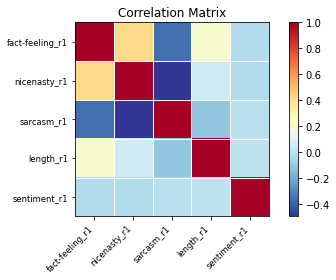

In [17]:
corr_matrix = np.corrcoef(triples[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

The condition number is reasonably high, but our correlatons do not seem too strong. Overall, our finding of significant effects for attack_r1/nasty_r1 and sarcasm_r1 persists with these new controls! This sort of robustness or sensitivity analysis is important for making sure your finding is compelling to yourself and to your audience. Consider doing other robustness checks, such as standardizing these variables before running the regression or adding [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors). (To be clear, the analysis above would likely not be sufficient as proof of a causal effect for a peer-reviewed journal; you would likely need a more conditional approach using matching, instruments or differences in differences.)

## <font color="red">*Exercise 2*</font>

<font color="red">Propose a simple causal model in your data, or a different causal model in the annotated Internet Arguments Corpus (e.g., a different treatment, a different outcome), and test it using a linear or logistic regression model. If you are using social media data for your final project, we encourage you to classify or annotate a sample of that data (either compuationally or with human annotators) and examine the effect of texts on replies to that text (e.g., Reddit posts on Reddit comments, Tweets on Twitter replies, YouTube video transcripts on YouTube comments or ratings). You do not need to make a graph of the causal model, but please make it clear (e.g., "X affects Y, and C affects both X and Y.").
    
<font color="red">Also consider using the [ConvoKit datasets](https://convokit.cornell.edu/documentation/datasets.html)! Anytime there is conversation, there is an opportunity to explore the effects of early parts of the conversation on later parts. We will explore this further in Week 8 on Text Generation and Conversation.
    
<font color="red">***Stretch*** (not required): Propose a more robust identification strategy using either matching, difference in difference, regression discontinuity, or an instrumental variable. Each of these methods usually gives you a more precise identification of the causal effect than a unconditional regression. Scott Cunningham's [Causal Inference: The Mixtape](https://mixtape.scunning.com/) is a free textbook on these topics, and all have good YouTube video explanations.

I would like to find the relation for the cause of an aggressive/sarcastic response. I hypothesis this has to do
directly with the non-alignment of beliefs with the original text. This calls for a study for 'text as a source'.
In the below cells I study the relation of agreement/disagrreement of response 1 with the original text and the
presence of sarcasm/ aggression in the corresponding dialogue.

In [24]:
y = triples['agree-disagree_r1']
X_cols = ['fact-feeling_r1','sarcasm_r1','attack_r1']
X = sm.add_constant(triples[X_cols])

lm = sm.OLS(y,X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      agree-disagree_r1   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     34.36
Date:                Wed, 23 Feb 2022   Prob (F-statistic):           3.47e-27
Time:                        22:59:11   Log-Likelihood:                -67.059
No. Observations:                1207   AIC:                             144.1
Df Residuals:                    1202   BIC:                             169.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4348      0.012     35.552      0.000       0.411       0.459
fact-feeling_r1    -0.0197      0.005     -3.606      0.000      -0.030      -0.009
nicenasty_r1        0.0050      0.013      0.377      0.706      -0.021       0.031
sarcasm_r1          0.0998      0.040      2.525      0.012       0.022       0.177
attack_r1           0.0634      0.012      5.174      0.000       0.039       0.087
==============================================================================
Omnibus:                       45.708   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.499
Skew:                           0.083   Prob(JB):                     2.15e-05
Kurtosis:                       2.368   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'attack_r1' and 'sarcasm_r1' show high confidence levels of affecting (being caused by disagreement)
with prior text. This is apparent and we know that people usually tend to meaner approach of text to
disregard text that do not align with their ideology.

In [36]:
trips = triples.dropna(subset=['questioning-asserting_r1'])
y = trips['questioning-asserting_r1']
X_cols = ['fact-feeling_r1','sarcasm_r1','nicenasty_r1', 'attack_r1']
X = sm.add_constant(trips[X_cols])

lm = sm.OLS(y,X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     questioning-asserting_r1   R-squared:                       0.022
Model:                                  OLS   Adj. R-squared:                  0.018
Method:                       Least Squares   F-statistic:                     6.163
Date:                      Wed, 23 Feb 2022   Prob (F-statistic):           6.62e-05
Time:                              23:16:36   Log-Likelihood:                -2582.1
No. Observations:                      1125   AIC:                             5174.
Df Residuals:                          1120   BIC:                             5199.
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8321      0.117      7.085      0.000       0.602       1.063
fact-feeling_r1     0.1195      0.053      2.238      0.025       0.015       0.224
sarcasm_r1         -0.8183      0.379     -2.160      0.031      -1.562      -0.075
nicenasty_r1       -0.2079      0.127     -1.633      0.103      -0.458       0.042
attack_r1           0.2441      0.119      2.048      0.041       0.010       0.478
==============================================================================
Omnibus:                       36.429   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.086
Skew:                          -0.377   Prob(JB):                     3.97e-08
Kurtosis:                       2.603   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

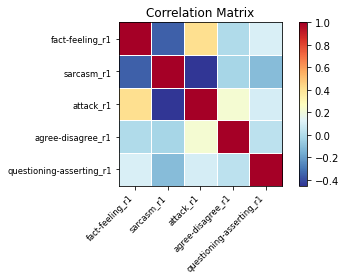

In [34]:
X_cols.extend(['agree-disagree_r1', 'questioning-asserting_r1'])
corr_matrix = np.corrcoef(trips[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

## Splitting training and test text
Above, we used a number of external measures of text, meaning that the measures were developed without any influence from this dataset. For annotations, it was Mechanical Turk workers measuring the text. For length, that is a mathematical count of characters. For sentiment, it was from a BERT model not trained on the Internet Arguments Corpus.

This is not always the case. Consider if we want to make a measure of the text based on topic modeling. We build an LDA topic model of these comments, then we select an appealingly relevant topic and measure what number of words from Topic 1 each comment uses. Can we put that measure in the regression? We could, but it would lead to a biased estimate of the true effect size because our measure is no longer external or exogenous. The measure and model are double-dipping from the same textual information. This is important to keep in mind for your final projects, and for a more thorough explanation and justification, you can read more about this in [Egami et al. 2018](https://arxiv.org/pdf/1802.02163.pdf).

One approach to this in the Internet Arguments Corpus would be to build measures with the `pairs` that were not also `triples`. Sometimes we have excess data like this that is similar enough to our regression data, which we can use without reducing our regression sample size. For example, you could abductively generate a keyword-count measure like "argumentativeness" or "thoughtfulness" from non-triple pairs that isn't already in the annotations, and then count the keywords in the triples. You could develop an LDA model or word embedding measurement on some of the data, and the use it to establish an inferential relationship on the rest of the data. This would avoid contamination.

## <font color="red">*Exercise 3*</font>

<font color="red">Propose a measure you could generate to fill in or improve upon the simple causal model you proposed above and how you would split the data (e.g., a % of your main data, a separate-but-informative dataset). You do not have to produce the measure.
    
<font color="red">***Stretch*** (not required): Produce the measure and integrate it into your statistical analysis. This could be a great approach for your final project!

# Text as mediator

What if text is instead the _mediator_, meaning it is effected by the teatment and effects the outcome? (A moderator influences the relationship a treatment has on the outcome. This figure from [Bhandari](https://www.scribbr.com/methodology/mediator-vs-moderator/) concisely shows the difference

<img src="https://cdn.scribbr.com/wp-content/uploads/2021/03/mediator-and-moderator-variables.png" alt="https://cdn.scribbr.com/wp-content/uploads/2021/03/mediator-and-moderator-variables.png" style="width:500px">
The moderating impact of a variable can simply be captured by in/excluding the variable alongside the purported cause of interest.)

Let's briefly return to the Internet Arguments Corpus triples and model the effect of the first comment ("quote") on the third comment ("response2") mediated by the second comment ("response1"). Unfortunately we don't have Turker annotations for the first comment, but we can propose a simple mediation model for the propogation of comment length from first to second to third. In other words: _Is there a causal chain of comment length through a conversation?_

A two-step mediation model consists of two linear models, one for each step. Let's create length_q and sentiment_q variables for our model.

In [14]:
triples['length_q'] = triples['quote'].apply(lambda x: len(x))

In [15]:
%%time

triples['sentiment_q'] = triples['quote'].apply(lambda x: sentiment(x[:512])[0]['score'])

CPU times: user 3min 6s, sys: 1.5 s, total: 3min 7s
Wall time: 3min 3s


To run this analysis, statsmodel (sm) has a convenient `Mediation` module that takes in two linear models and outputs a mediation model.

In [16]:
# Mediation analysis
y = triples['length_r1']
X_cols = ['sentiment_q','length_q']
X = sm.add_constant(triples[X_cols])
mediator_model = sm.OLS(y,X)

# For the second step of the mediation model, we can add in other predictors.
y = triples['length_r2']
X_cols = ['sentiment_q','length_q','fact-feeling_r1','nicenasty_r1','sarcasm_r1','length_r1','sentiment_r1']
X = sm.add_constant(triples[X_cols])
outcome_model = sm.OLS(y,X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='length_q', mediator='length_r1').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.315455,-6.774322,7.681605,0.912
ACME (treated),0.315455,-6.774322,7.681605,0.912
ADE (control),0.073413,0.024109,0.124060,0.002
ADE (treated),0.073413,0.024109,0.124060,0.002
Total effect,0.388868,-6.725020,7.728778,0.894
Prop. mediated (control),0.990036,0.622708,1.350092,0.018
Prop. mediated (treated),0.990036,0.622708,1.350092,0.018
ACME (average),0.315455,-6.774322,7.681605,0.912
ADE (average),0.073413,0.024109,0.124060,0.002
Prop. mediated (average),0.990036,0.622708,1.350092,0.018


It looks like the Average Causal Mediated Effect (ACME) is not significantly different from zero, but the Average Direct Effect (ADE) is. This suggests that the true causal relationship here is more likely:

_length_q -> length_r2_

than

_length_q -> length_r1 -> length_r2_

What do you think explains that relationship?

Once you are done with the Internet Arguments Corpus `iac_v1.1.zip` file, you may want to delete it if you are going to `git push` this directory because of [GitHub's limits on file sizes above 100 MB](https://docs.github.com/en/repositories/working-with-files/managing-large-files/about-large-files-on-github).

In [17]:
os.remove('iac_v1.1.zip')

## <font color="red">*Exercise 4*</font>

<font color="red">Propose a mediation model related to the simple causal model you proposed above (ideally on the dataset you're using for your final project). If you have measures for each variable in the model, run the analysis: You can just copy the "Mediation analysis" cell above and replace with your variables. If you do not have measures, do not run the analysis, but be clear as to the effect(s) you would like to estimate and the research design you would use to test them.

# Text as confounder
The causal effect we're interested in estimating might not be our causal relationship of interest. Instead, it could be another variable that affects both our treatment and outcome, known as a _confounder_. Recall the [Keith et al. 2020](https://aclanthology.org/2020.acl-main.474.pdf) figure showing the role of a confounder.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" style="width:500px">

Why do we need to control for confounders? If we didn't, we might correctly find that the treatment and outcome are correlated, but rather than one causing the other, they could both be caused by a third variable. For example, if we are studying the effect of the journal a paper is published in on the citations of the paper, we may be worried that the text of the article affects both whether it is published by the journal and whether people cite it.

The factors we controlled for in the Internet Arguments Corpus could be seen as confounders, but there are also specific methods to control for text confounders. As an example, we will walk through the method proposed by [Pryzant et al. (2018)](https://nlp.stanford.edu/pubs/pryzant2018lexicon.pdf).

Say that we want to know the effect of product descriptions on product popularity. If I'm a shoe seller, how should I describe my shoes to maximize sales? Suppose I have data on sales of other shoes and want to learn from it:

| Description   | Brand   | Sales |
|---------------|---------|-------|
| buy shoes !     | addidas | 15    |
| fresh nike shoes !  | nike    | 35    |
| nice nike shoes ! | nike    | 17    |

It looks like "nike" is associated with higher sales! But that doesn't help me very much because I can't just advertise my shoes as Nikes. That would be incorrect and illegal (false advertising). What if we could build a lexicon of words like "nike" associated with certain brands and control for that in my analysis? We could then identify brand-agnostic words like "fresh" that have the causal effect of interest. This is the approach by Pryzant et al.

Instead of shoes, we're going to work with Consumer Financial Protection Bureau (CFPB) complaints. When US residents complain about financial products (e..g, mortgages, credit reports), the CFPB sometimes handles these on a "timely basis (<15 days)" and sometimes not. If you want to submit a complaint, how should you word it so you get a timely response? We want to control for the differences in wording that result from different products to identify the causal effect of interest. For example, if saying "mortgage" is associated with a timely response, that doesn't mean you should throw "mortgage" into your complaint about a credit report.

Let's download the data and construct a Pandas DataFrame!

In [18]:
url = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip'

req = requests.get(url)

filename = url.split('/')[-1]
with open(filename,'wb') as output_file:
    output_file.write(req.content)
print('Downloaded file: ' + url)

Downloaded file: https://files.consumerfinance.gov/ccdb/complaints.csv.zip


In [19]:
zipfile.ZipFile('complaints.csv.zip').extractall('')

In [20]:
complaints = pd.read_csv('complaints.csv')
complaints

/Users/sudhamshu.hosamane/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-05-03,Student loan,Private student loan,Struggling to repay your loan,Can't get other flexible options for repaying ...,NaN,NaN,Ameritech Financial,FL,33023.0,NaN,Consent not provided,Web,2019-05-15,Untimely response,No,NaN,3231257
1,2022-01-15,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,Experian Information Solutions Inc.,NV,89146.0,NaN,NaN,Web,2022-01-15,In progress,Yes,NaN,5111916
2,2021-12-08,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,First Progress Card was notified throughout th...,NaN,Synovus Bank,DE,19805.0,NaN,Consent provided,Web,2021-12-08,Closed with explanation,Yes,NaN,4984749
3,2021-12-31,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,"As by Law, under 15 U.S Code 1601- Congression...",Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MD,20744.0,NaN,Consent provided,Web,2021-12-31,Closed with explanation,Yes,NaN,5057575
4,2019-12-04,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,"General Motors Financial Company, Inc.",NJ,8628.0,NaN,Consent not provided,Web,2019-12-04,Closed with non-monetary relief,Yes,NaN,3458216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494980,2017-02-09,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,I have disputed my debts several times with no...,NaN,Bonneville Billing and Collections,UT,84054.0,Servicemember,Consent provided,Web,2017-02-09,Closed with explanation,Yes,No,2334969
2494981,2015-04-29,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,My father died in XX/XX/XXXX. Left me his only...,NaN,"CITIBANK, N.A.",OK,74066.0,NaN,Consent provided,Web,2015-04-29,Closed with explanation,Yes,No,1352738
2494982,2017-03-31,Credit reporting,NaN,Credit reporting company's investigation,No notice of investigation status/result,cfbp i would Like to file a complaint on Exper...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MN,55379.0,NaN,Consent provided,Web,2017-03-31,Closed with non-monetary relief,Yes,Yes,2412926
2494983,2017-01-16,Credit reporting,NaN,Incorrect information on credit report,Account status,My husband and I are in the middle of an FHA S...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,30215.0,NaN,Consent provided,Web,2017-01-16,Closed with explanation,Yes,No,2292586


In [21]:
complaints['timely'] = complaints['Timely response?'].apply(lambda x: 1 if (x == 'Yes') else 0)

Very interesting! So our goal is to build a lexicon associated with the `Product` column in order to better identify the effect of wording choices in `Consumer complaint narrative` on whether `Timely response?` is `Yes` or `No`. Fortunately Pryzant et al. made a very convenient package to build such a lexicon.

In [24]:
# !pip install causal-attribution

  Using cached sklearn-0.0-py2.py3-none-any.whl


In [25]:
import causal_attribution

We will use their function called `causal_attribution.score_vocab()`. This takes as input a vocabulary of words that we want to assess, the CSV file with data, and a dictionary that tells the function which column of the CSV is your input, your control, and your intended prediction. What vocabulary should we use? Let's put in some words related to the `Product` column as well as some words that may causally effect `Timely response?`. You can also run it on much larger vocabularies (Pryzant et al. use 2000), but it will take more time to compute.

In [26]:
product_num = complaints['Product'].value_counts()
product_num

Credit reporting, credit repair services, or other personal consumer reports    973881
Debt collection                                                                 407551
Mortgage                                                                        347404
Credit reporting                                                                140430
Credit card or prepaid card                                                     135423
Checking or savings account                                                     113389
Credit card                                                                      89190
Bank account or service                                                          86206
Student loan                                                                     65163
Money transfer, virtual currency, or money service                               37275
Consumer Loan                                                                    31600
Vehicle loan or lease                      

In [27]:
%%time

importance_scores = causal_attribution.score_vocab(
    vocab=[
           # Words I expect to be associated with Product
           'credit','loan','bank','card','mortgage','transfer','account','money','virtual','paypay','prepaid','lease',
           # Words I expect to be associated with timeliness
           'fraud','crime','urgent','please','help',
           # Words I expect to not be associated with either
           'bad','good','help','thank','why','husband','wife','family'
          ],
    csv='complaints.csv',
    delimiter=",",
    name_to_type={
        'Consumer complaint narrative': 'input',
        'Product': 'control',
        'Timely response?': 'predict',
    })

importance_scores['Timely response?']['Yes']

/Users/sudhamshu.hosamane/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magic.py:187: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 23.4 s, sys: 1.77 s, total: 25.2 s
Wall time: 27.9 s


[('mortgage', 3.583950040570926),
 ('please', 3.320432700798847),
 ('transfer', 3.262779381373548),
 ('thank', 2.854906315124026),
 ('UNK', 2.7316092510009184),
 ('urgent', 2.682648691232316),
 ('crime', 2.517495307023637),
 ('prepaid', 2.0892761925642844),
 ('wife', 0.8627179093382438),
 ('bank', 0.6609743913868442),
 ('husband', 0.48079247257555835),
 ('why', 0.446945336079807),
 ('account', 0.3921612564606676),
 ('help', 0.29709534312132746),
 ('card', 0.26418338237817807),
 ('credit', 0.2466758247173857),
 ('fraud', 0.1763091488246573),
 ('good', 0.1456455591833219),
 ('paypay', 0.08276165265124291),
 ('help', 0.06907483354734723),
 ('PAD', 0.029181787744164467),
 ('money', 0.0108653078837051),
 ('loan', -0.05878074005886447),
 ('bad', -0.07388655921386089),
 ('lease', -0.08521243336144835),
 ('virtual', -0.09871945630948176),
 ('family', -0.13988636783324182)]

That output isn't that intuitive, but in theory, higher scores correspond to words that better explain `Timely response?` when controlling for `Product`. This suggests that saying `mortgage` is actually a good way to get a timely response even if your complaint isn't about a mortgage! That's interesting. As with other causal inference approaches, we can take a closer look at our data to help explain the results. For example, let's look at whether the `Mortgage` `Product` category had a very high timeliness rate. 

You can ignore 'UNK' and 'PAD', but if you're curious, 'UNK' refers to all tokens that are in the corpus but not in the vocab, and 'PAD' refers to padding added to texts to make their length consistent—-this is common in neural networks because the network is usually designed with a certain input length, so you need to add padding tokens if the input is shorter. You will see padding very frequently in other text-based neural networks and should keep it in mind when building your own in the future.

In [28]:
product_timelies = complaints.groupby('Product').agg({'timely': 'sum'}).sort_values(by=['timely'],ascending=False)
pcts = product_timelies.divide(product_num,axis=0).sort_values(by=['timely'],ascending=False)
pcts

,timely
Credit reporting,0.997899
"Credit reporting, credit repair services, or other personal consumer reports",0.993706
Credit card,0.988990
Credit card or prepaid card,0.988178
Checking or savings account,0.987838
Prepaid card,0.986908
Student loan,0.982214
Mortgage,0.980680
"Money transfer, virtual currency, or money service",0.980228
Vehicle loan or lease,0.975783


Mortgage is in the middle of the pack, so it doesn't seem like mortgages in themselves are extremely likely to be responded to in a timely manner. This is something you can explore in more detail if you have time and interest. For example, you can check for which products the word `mortgage` is most strongly associated with timeliness.

Once you are done with the CFPB `complaints.csv.zip` and `complaints.csv` files, you may want to delete them if you are going to `git push` this directory because of [GitHub's limits on file sizes above 100 MB](https://docs.github.com/en/repositories/working-with-files/managing-large-files/about-large-files-on-github).

In [ ]:
os.remove('complaints.csv.zip')

In [ ]:
os.remove('complaints.csv')

## <font color="red">*Exercise 5*</font>

<font color="red">Propose a confounder in your final project data that could be controlled for using the method of Pryzant et al. Generate an appropriate CSV file and run it on some vocabulary in your corpus. If you have no such confounder available for your final project, you can use `complaints.csv` with a new vocabulary or for different variables (e.g., `Sub-product`, `Company`) or you can further explore the interesting case of `mortgage`. Also keep in mind the [ConvoKit datasets](https://convokit.cornell.edu/documentation/datasets.html). In any case, be sure to interpret the results. What does the output of `causal_attribution.score_vocab()` mean in your context?

# "Causally sufficient" embedding and topic models
Our final example of causal inference with text is from Victor Veitch (now a statistics and CS professor at UChicago), Sridhhar, and Blei. You may recall Blei as the lead developer of LDA, HDP, and Dynamic topic models, among other amazing contributions to content analysis.

Their 2020 paper, ["Adapting Text Embeddings for Causal Inference"](https://arxiv.org/abs/1905.12741), proposes reducing the dimensions of contextual text embeddings (from BERT) in a manner that preserves causally relevant text signals. For example: "Does adding a theorem to a paper affect its chance of acceptance?" We can apply supervised dimensionality reduction to make the embedding easier to analyze (i.e., lower dimension) but preserve information about whether theorems are present. Similar to Pryzant et al., Veitch et al. have a great [GitHub respository](https://github.com/blei-lab/causal-text-embeddings) with the data and code for their paper, and their dataset of computer science papers, PeerRead, has its own great [repo](https://github.com/allenai/PeerRead).

Their code is somewhat too hefty and farflung for this assignment, but for your future research, keep in mind that you can adjust your textual objects (e.g., keyword counts, topic models, word embeddings) for causal models. Bringing together unsupervised machine learning with causal inference is an exciting and rapidly developing field!

## <font color="red">*Exercise 6*</font>

<font color="red">Pick one other paper on causal inference with text from the ["Papers about Causal Inference and Language
" GitHub repository](https://github.com/causaltext/causal-text-papers). Write at least three sentences summarizing the paper and its logic of design in your own words.
    
<font color="red">***Stretch*** (not required): Skim a few more papers. The causal world is your textual oyster!